# Uso de transferencia de conocimiento para la clasificación de un dataset pequeño
## Autor: Pablo Benayas Penas
1. Objetivo: a partir de una red neuronal preentrenada, crear un modelo con el que poder clasificar las imágenes de distintos tipos de osos.
2. Hoja de ruta:
    1. Importar librerías. 
    2. Crear directorio en jupyter donde dividir las fotos de osos en:
        1. Train, validation, test.
        2. black, grizzly, teddys.
    3. Visualización de las fotos.
    4. Dimensiones de las fotos.
    5. Crear un modelo inicial a partir de la red neuronal preentrenada, y evaluar sus resultados
        1. Generar modelo.
        2. Crear datasets 'train', 'validation' y 'test'.
        3. Ver si los datasets tienen las clases balanceadas.
        4. Correr el modelo
    6. Mejorar el modelo:
        1. Hacer grid search de hiperparámetros.
    7. Correr modelo con la mejor combinación de hiperparámetros y evaluar resultados. 
3. ¡Empecemos!

# Importar librerías

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import keras
from keras.layers import *
from keras.applications import ResNet50V2, Xception, VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input as preprocess_ResNet50V2
from keras.applications.xception import preprocess_input as preprocess_Xception
from keras.applications.vgg16 import preprocess_input as preprocess_VGG16
from keras.optimizers import Adam
from numpy import expand_dims
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV 
from IPython.display import Image
from numpy.random import seed
import pandas as pd

# Distribución del dataset de osos en el directorio de jupyter





1. Las observaciones son divididas en train, validation y test.
    1. Con 'train' entrenamos el modelo, con 'validation' evitamos overfitting en el entrenamiento y con 'test' evaluamos la precisión del modelo sobre nuevas fotos.









2. A su vez, las fotos son divididas por las categorías black, grizzly y teddys









### IMPORTANTE: Las fotos en train van de '00' a '59', validation de '60' a '69' y test de '70' a '79'

#### El directorio de jupyter tiene 3 subcarpetas: train, validation y test

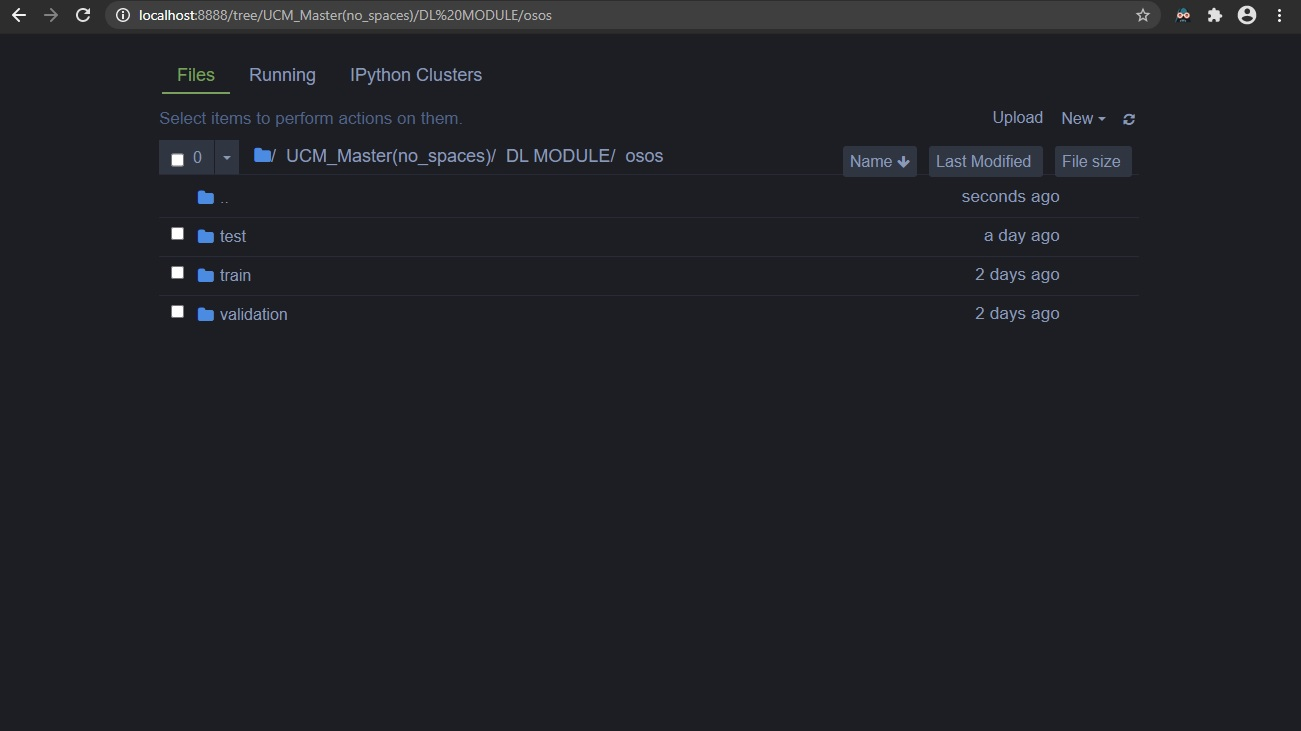

In [3]:
Image(filename = "train_val_test.jpg", width=700, height=700) 

#### Dentro de train, test y validation, las fotos son a su vez divididas en tres categorías: black, grizzly y teddys

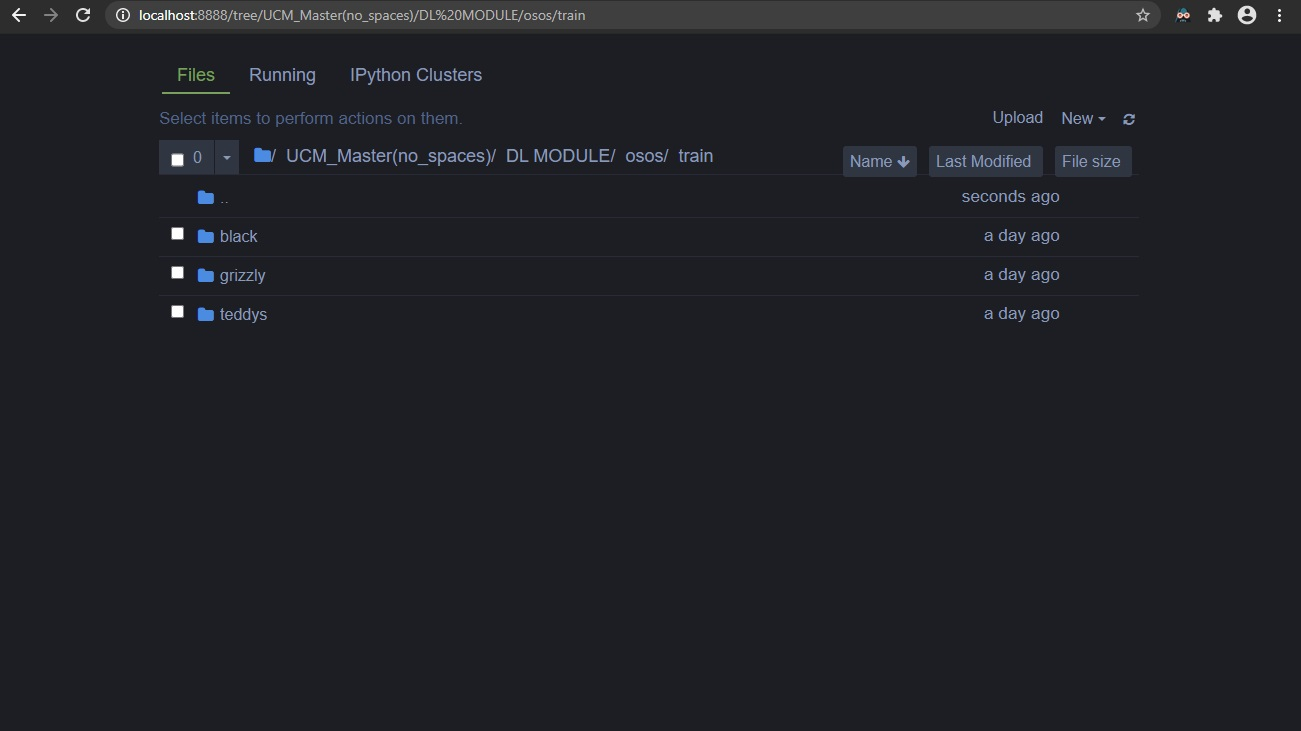

In [4]:
Image(filename = "within_train.jpg", width=700, height=700)

#### Si nos vamos a la carpeta de 'teddys' de la carpeta 'test', se puede observar que hay 10 fotos

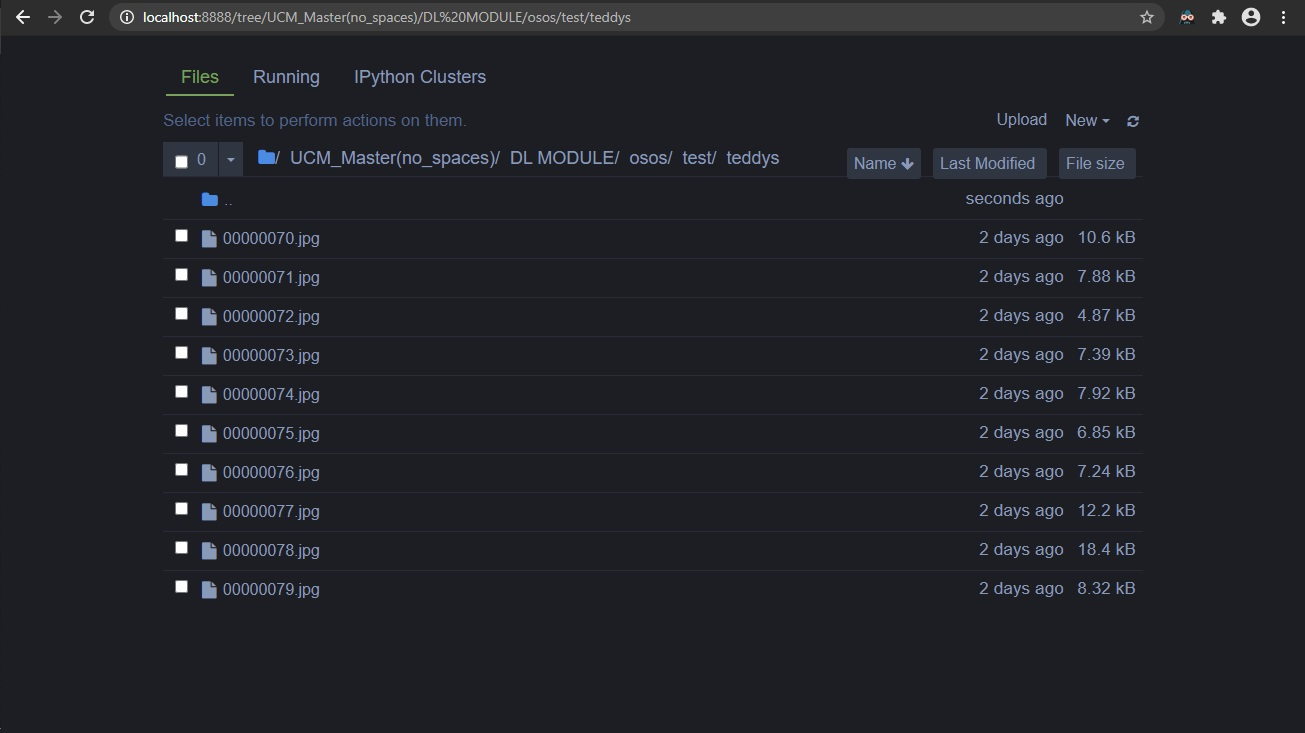

In [5]:
Image(filename = "test_teddys.jpg", width=700, height=700) 

# Visualización de las fotos

Oso negro


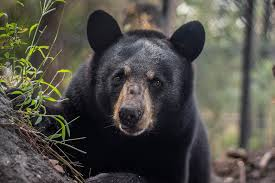

In [6]:
print('Oso negro')
base_path = 'osos/train'
Image(filename = base_path + '/black/00000000.jpg')

Oso pardo


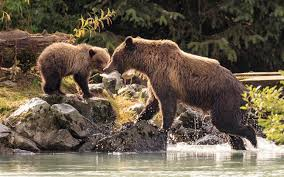

In [7]:
print('Oso pardo')
Image(filename = base_path + '/grizzly/00000000.jpg')

Oso peluche


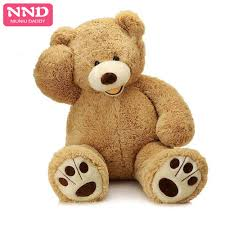

In [8]:
print('Oso peluche')
Image(filename = base_path + '/teddys/00000000.jpg')

# Dimensiones de las fotos

In [9]:
a = image.load_img(base_path + '/teddys/00000000.jpg')
print('picture_shape: ({}, {}, {})'.format(a.size[0], a.size[1], len(a.mode)))  

picture_shape: (225, 225, 3)


# Modelo
### Estrategia:
1. Crear un primer modelo
2. Mejorar el modelo con GridSearch de hiperparámetros

# Primer modelo:
1. La red neuronal preentrenada que he elegido para el primer modelo es 'Xception'. El argumento 'include_top' nos permite eliminar la última capa del modelo preentrenado. Posteriormente, añadiremos capas adicionales a dicho modelo para poder usarlo en nuestro problema de clasificación de osos. 
    
    
    
2. Dado que voy a añadir la capa 'Flatten()', tengo que especificar el argumento 'input_shape' que se refiere a las dimensiones de los datos que vamos a pasar al modelo. En nuestro caso, el input_shape son las dimensiones de las fotos: (225,225,3)
  
  
  
3. 'base_model.ouput': Seleccionamos la última capa del modelo preentrenado. Dado que es un modelo secuencial, las nuevas capas se crean a partir de las anteriores.
  
  
  
4. pred_layer: IMPORTANTE: queremos que la última capa tenga las mismas unidades que el número de categorías (3). Usamos 'softmax' para que nos devuelva las probabilidades de pertenecer a cada una de las categorías. Por tanto, la predicción que genera esta última capa es de la siguiente forma:  [prob_black, prob_grizzly, prob_teddys] 



5. Dado que la red preentrenada tiene muchas capas y por tanto viene 'cargada' de parámetros entrenados, no vamos a añadir muchas capas.
  
  
  
 
6. Con 'Model(inputs=base_model.input, outputs=pred_layer)', uno todas las capas en un mismo modelo.
 
 
 
7. Finalmente, especificio que solo quiero entrenar las capas que he añadido al final

In [104]:
base_path = 'osos/train'

base_model = Xception(weights='imagenet', include_top=False, input_shape=(225, 225, 3)) 

layer_preceding_the_last_layer_of_base_model = base_model.output
layer = Flatten()(layer_preceding_the_last_layer_of_base_model)  
layer = Dense(10, activation='relu')(layer)
pred_layer = Dense(3, activation='softmax')(layer) 

model = Model(inputs=base_model.input, outputs=pred_layer)

num_layers_base_model, num_layers_total = len(base_model.layers), len(model.layers) 

for layer in model.layers[:num_layers_base_model]:
    layer.trainable=False
for layer in model.layers[num_layers_base_model:]:
    layer.trainable=True
    
model.summary() 

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 225, 225, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 112, 112, 32) 864         input_17[0][0]                   
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 112, 112, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 112, 112, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### Preparo el dataset para el primer modelo:
1. Creo 3 datasets: train, validation y test.



2. En la función 'flow_from_directory' especifico:
    1. La ruta donde se encuentra la carpeta principal que a su vez contiene las carpetas de cada una de las categorías.
    2. El ancho y largo de las fotos.
    3. El tipo de color de las fotos (el cual representa la tercera dimensión del input shape).
    4. El nombre de las categorías.
    5. El batch con el que voy a entrenar el modelo.
    6. El tipo de clase (categórica en nuestro caso).
    7. Si queremos barajar aleatoriamente los datos.
    
    
    
3. Este proceso se tiene que repetir para los tres datasets.

In [5]:
datagen = ImageDataGenerator(preprocessing_function=preprocess_Xception) 

train_generator = datagen.flow_from_directory("osos/train", 
                                                  target_size=(225,225),
                                                  color_mode='rgb',
                                                  classes = ['black','grizzly','teddys'],
                                                  batch_size=32,
                                                  class_mode='categorical',
                                                  shuffle=True) 

validation_generator = datagen.flow_from_directory(directory="osos/validation",
                                                  target_size=(225,225),
                                                  color_mode='rgb',
                                                  classes = ['black','grizzly','teddys'],
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=True)

test_generator = datagen.flow_from_directory(directory="osos/test",
                                                  target_size=(225,225),
                                                  color_mode='rgb',
                                                  classes = ['black','grizzly','teddys'],
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=True) 

Found 180 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.


# ¿Están los datasets balanceados?
1. Con el atributo '.filenames' podemos acceder a los archivos guardados en el dataset

In [6]:
train = pd.DataFrame({'observaciones en train':train_generator.filenames})
train

,observaciones en train
0,black\00000000.jpg
1,black\00000001.jpg
2,black\00000002.jpg
3,black\00000003.jpg
4,black\00000004.jpg
...,...
175,teddys\00000055.jpg
176,teddys\00000056.jpg
177,teddys\00000057.jpg
178,teddys\00000058.jpg


### Como se puede observar, los 3 datasets están balanceados

In [7]:
dict_values = {'train': train_generator.filenames,
               'validation': validation_generator.filenames,
               'test': test_generator.filenames}

df = pd.DataFrame()
final = pd.DataFrame()  

for dataset in dict_values.keys():   
    df[dataset] = dict_values[dataset]
    categ = df[dataset].str.findall(r'[a-z]*').apply(lambda row: row[0]) 
    df[dataset] = categ
    
    final['balanceo '+ dataset] = df[dataset].value_counts()
    df = pd.DataFrame()

final

,balanceo train,balanceo validation,balanceo test
black,60,10,10
teddys,60,10,10
grizzly,60,10,10


### Entreno el modelo:

1. Más adelante haremos la optimización de hiperparámetros. Por ahora, elijo 'Adam' como optimizador. El batch que elijo es el que especificamos anteriormente en train_generator (32). Epochs la dejo a 10.



2. IMPORTANTE: batch se refiere al número de observaciones que utilizamos en cada iteración. De esta manera el resultado de la 'loss function' es la MEDIA del error de dichas observaciones. Lo mismo sucede con la actualización de la matriz de pesos. 



3. Epoch, por el contrario, se refiere al número de veces que vamos a usar TODO el dataset en el entrenamiento.



4. 'early_stop': Tras haber alcanzado la mínima 'val_loss', el modelo seguirá iterando 7 epochs más. Si en esas 7 epochs no habido valor que supere la 'val_loss' mínima, entonces el modelo finalizará. Utilizo 'val_loss' frente 'val_accuracy' porque 'val_loss' nos permite afinar más el modelo para evitar overfitting. 

In [106]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train=train_generator.n//train_generator.batch_size

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')


model.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=10,
                    validation_data = validation_generator,
                    callbacks = [early_stop],
                    shuffle = False)

train_acc = round(model.evaluate_generator(generator=train_generator)[1],3)  
val_acc = round(model.evaluate_generator(generator=validation_generator)[1],3)  
test_acc = round(model.evaluate_generator(generator=test_generator)[1],3) 

Epoch 1/10
5/5 [==============================] - 97s 19s/step - loss: 2.1060 - accuracy: 0.4938 - val_loss: 0.0000e+00 - val_accuracy: 0.9000
Epoch 2/10
5/5 [==============================] - 78s 16s/step - loss: 0.6787 - accuracy: 0.8176 - val_loss: 0.0000e+00 - val_accuracy: 0.9667
Epoch 3/10
5/5 [==============================] - 85s 17s/step - loss: 0.2235 - accuracy: 0.9054 - val_loss: 3.5763e-07 - val_accuracy: 0.8333
Epoch 4/10
5/5 [==============================] - 90s 18s/step - loss: 0.2299 - accuracy: 0.9392 - val_loss: 9.5367e-07 - val_accuracy: 1.0000
Epoch 5/10
5/5 [==============================] - 96s 19s/step - loss: 0.0820 - accuracy: 0.9662 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/10
5/5 [==============================] - 96s 19s/step - loss: 0.0446 - accuracy: 0.9797 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 105s 21s/step - loss: 0.0100 - accuracy: 0.9937 - val_loss: 0.0000e+00 - val_accuracy: 1.000

# Evaluación

In [107]:
print('train_acc: {}, valid_acc: {}, test_acc: {}'.format(train_acc, val_acc, test_acc)) 

train_acc: 0.983, valid_acc: 1.0, test_acc: 1.0


# Pruebo un segundo modelo en el que añado las siguientes capas:
1. layer = Conv2D(10, (5, 5), strides = (1,1), padding='same', kernel_initializer = glorot_uniform(seed=0))(layer)  
2. layer = BatchNormalization(axis = 3)(layer) 
3. layer = Activation('relu')(layer) 
4. layer = Flatten()(layer)
5. layer = Dense(256, activation='relu')(layer) 
6. layer = BatchNormalization()(layer) 



El resto de pasos son iguales



### El objetivo aquí es confirmar que añadir más capas no mejora la 'accuracy' del modelo

### Al añadir 'Conv2D' hay que prestar atención en las dimensiones de la capa anterior

In [8]:
base_path = 'osos/train'
base_model = Xception(weights='imagenet', include_top=False, input_shape=(225, 225, 3)) 

base_model.output 

<tf.Tensor 'block14_sepconv2_act/Relu:0' shape=(None, 7, 7, 2048) dtype=float32>

In [108]:
layer = base_model.output

# Conv2D: Creo 10 filtros con un kernel de (5,5). La ventana del filtro (5,5) será repetida 3 
# veces, ya que las dimensiones de la capa anterior equivalen a una foto de 7*7 píxeles. 
layer = Conv2D(10, (5, 5), strides = (1,1), padding='same', 
               kernel_initializer = glorot_uniform(seed=0))(layer)  
layer = BatchNormalization(axis = 3)(layer) 
layer = Activation('relu')(layer) 
layer = Flatten()(layer)
layer = Dense(256, activation='relu')(layer) 
layer = BatchNormalization()(layer) 

layer = Dense(10, activation='relu')(layer)
pred_layer = Dense(3, activation='softmax')(layer) 

model2 = Model(inputs=base_model.input, outputs=pred_layer)

num_layers_base_model, num_layers_total = len(base_model.layers), len(model2.layers) 

for layer in model2.layers[:num_layers_base_model]:
    layer.trainable=False
for layer in model2.layers[num_layers_base_model:]:
    layer.trainable=True
    
    
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

step_size_train = train_generator.n//train_generator.batch_size

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')  

model2.fit_generator(generator=train_generator,
                    steps_per_epoch=step_size_train,
                    epochs=10,
                    validation_data = validation_generator,
                    callbacks = [early_stop],
                    shuffle = False)

train_acc2 = round(model2.evaluate_generator(generator=train_generator)[1],3)  
val_acc2 = round(model2.evaluate_generator(generator=validation_generator)[1],3)  
test_acc2 = round(model2.evaluate_generator(generator=test_generator)[1],3) 

Epoch 1/10
5/5 [==============================] - 134s 27s/step - loss: 0.8223 - accuracy: 0.6938 - val_loss: 3.9339e-06 - val_accuracy: 0.8667
Epoch 2/10
5/5 [==============================] - 110s 22s/step - loss: 0.3414 - accuracy: 0.8716 - val_loss: 0.0000e+00 - val_accuracy: 0.8667
Epoch 3/10
5/5 [==============================] - 106s 21s/step - loss: 0.1923 - accuracy: 0.9527 - val_loss: 4.2438e-05 - val_accuracy: 0.9667
Epoch 4/10
5/5 [==============================] - 105s 21s/step - loss: 0.1694 - accuracy: 0.9527 - val_loss: 7.5695e-05 - val_accuracy: 0.9667
Epoch 5/10
5/5 [==============================] - 106s 21s/step - loss: 0.2655 - accuracy: 0.9595 - val_loss: 7.7841e-05 - val_accuracy: 0.9667
Epoch 6/10
5/5 [==============================] - 104s 21s/step - loss: 0.1169 - accuracy: 0.9797 - val_loss: 2.8523e-04 - val_accuracy: 1.0000
Epoch 7/10
5/5 [==============================] - 113s 23s/step - loss: 0.1023 - accuracy: 0.9937 - val_loss: 1.6032e-04 - val_accuracy:

# Evaluamos si 'model2' ofrece mejores resultados que 'model'

In [109]:
print('train_acc: {}, valid_acc: {}, test_acc: {}'.format(train_acc2, val_acc2, test_acc2)) 

train_acc: 0.983, valid_acc: 1.0, test_acc: 0.967


### Comparamos y vemos que 'model' (que tiene menos capas añadidas) tiene mismo resultado de acierto que 'model2' en 'train' y 'validation', pero mayor porcentaje de acierto en 'test'.



Por tanto, el modelo ganador es 'model'

In [112]:
print('MODELO "model2" -> train_acc: {}, valid_acc: {}, test_acc: {}'.format(train_acc2, val_acc2, test_acc2)) 
print('\n')
print('MODELO "model"  -> train_acc: {}, valid_acc: {}, test_acc: {}'.format(train_acc, val_acc, test_acc)) 

MODELO "model2" -> train_acc: 0.983, valid_acc: 1.0, test_acc: 0.967


MODELO "model"  -> train_acc: 0.983, valid_acc: 1.0, test_acc: 1.0


### Predicciones con 'test' y 'validation
1. Uso la función vista en clase 'predict_image()' para visualizar las predicciones



2. Vemos que el modelo tiene un 100% de acierto en ambos data sets

In [113]:
class_dict = {v:k for k, v in train_generator.class_indices.items()} 

def predict_image(path):
    img = image.load_img(path)
    img = img.resize((225, 225))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_Xception(data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

paths = ['osos/validation/black', 'osos/validation/grizzly', 'osos/validation/teddys', 
         'osos/test/black', 'osos/test/grizzly', 'osos/test/teddys']
    
for i in paths:
    print('\n\n')
    pred_path = i
    print('Ruta: {}'.format(i[5:]))
    if re.search('validation', i) != None:
        for i in range(60,70):
            predict_image(pred_path + '/000000'+str(i)+'.jpg')
    else:
        for i in range(70,80):
            predict_image(pred_path + '/000000'+str(i)+'.jpg')




Ruta: validation/black
black
black
black
black
black
black
black
black
black
black



Ruta: validation/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: validation/teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys



Ruta: test/black
black
black
black
black
black
black
black
black
black
black



Ruta: test/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: test/teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys


### Vemos que en 'train' falla en unos pocos ( 3 de 180 fotos)

In [114]:
for i in ['osos/train/black', 'osos/train/grizzly', 'osos/train/teddys']:
    print('\n\n')
    pred_path = i
    print('Ruta: {}'.format(i[5:]))
    for i in range(60):
        if i < 10:
            predict_image(pred_path + '/0000000'+str(i)+'.jpg')
        else:
            predict_image(pred_path + '/000000'+str(i)+'.jpg') 




Ruta: train/black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
grizzly
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
grizzly
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black



Ruta: train/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
black
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: train/teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
t

# Optimización de hiperparámetros:
### El primer modelo que hemos creado es bastante bueno. 
### ¿Existen otras combianciones de parámetros que consigan igualarlo o incluso llegar a un accuracy en el train del 100%?

### Creo la función 'create_model()' que tiene dos argumentos:
1. 'imported_model' donde especifico el nombre de la red neuronal preentrenada que voy a importar.
    1. Solo vamos a tener dos opciones a importar: Xception y VGG16. Elijo estas dos redes neuronales porque son las que mejor 'accuracy' tienen:
2. 'batch' donde especifico el número de observaciones (fotos) que voy a utilizar en cada iteración del entrenamiento.

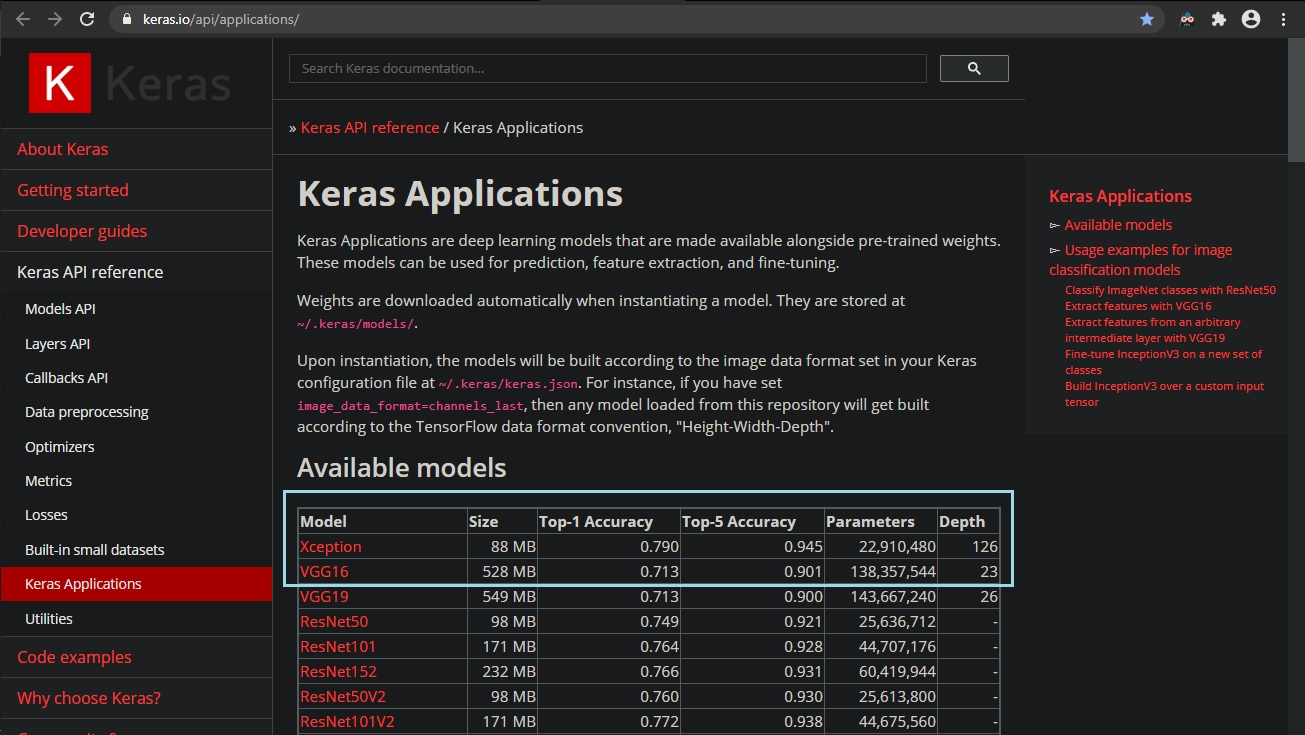

In [14]:
Image(filename = "imported_CNNs.jpg", width=700, height=700) 

### Con esta función repito los pasos que realicé anteriormente para la creación del modelo y los datasets.

In [2]:
def create_model(imported_model = 'Xception', batch = 32):
    base_path = 'osos/train'
    
    if imported_model == 'Xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(225, 225, 3)) 
    else: 
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(225, 225, 3))
    base_model_preceding_the_last_layer = base_model.output
    layer = Flatten()(base_model_preceding_the_last_layer)
    layer = Dense(10, activation='relu')(layer) 
    pred_layer = Dense(3, activation='softmax')(layer) #final layer with softmax activation

    model = Model(inputs=base_model.input, outputs=pred_layer)

    num_layers_base_model, num_layers_total = len(base_model.layers), len(model.layers) 

    for layer in model.layers[:num_layers_base_model]:
        layer.trainable=False
    for layer in model.layers[num_layers_base_model:]:
        layer.trainable=True
    
    if imported_model == 'Xception':
        datagen = ImageDataGenerator(preprocessing_function=preprocess_Xception) 
    else: 
        datagen = ImageDataGenerator(preprocessing_function=preprocess_VGG16) 

    train_generator = datagen.flow_from_directory(base_path, # this is where you specify the path to the main data folder
                                                        target_size = (225,225),
                                                        color_mode = 'rgb',
                                                        classes = ['black','grizzly','teddys'],
                                                        batch_size = batch,
                                                        class_mode = 'categorical',
                                                        shuffle = True) 

    validation_generator = datagen.flow_from_directory(directory="osos/validation",
                                                      target_size=(225,225),
                                                      color_mode='rgb',
                                                      classes = ['black','grizzly','teddys'],
                                                      batch_size=1,
                                                      class_mode='categorical',
                                                      shuffle=True)

    test_generator = datagen.flow_from_directory(directory="osos/test",
                                                      target_size=(225,225),
                                                      color_mode='rgb',
                                                      classes = ['black','grizzly','teddys'],
                                                      batch_size=1,
                                                      class_mode='categorical',
                                                      shuffle=True)
    
    return model, train_generator, validation_generator, test_generator

### Creo la función que genera todas las posibles combinaciones de hiperparámetros que hayamos especificado.

1. Importante: se puede hacer un grid search tan grande como valores queramos añadir a los hiperparámetros. Además, hay una gran variedad de hiperparámetros que podemos incluir como el tipo de red preentrendada, el optimizador (y dentro del optimizador el learning rate), batch, epochs, las capas que añadimos a la red preentrenada, las semillas en el entrenamiento e incluso los callbacks en fit_generator().
   
   
   
2. Para este ejercicio he seleccionado como hiperparámetros el tipo de red preentrenada, el optimizador y el batch. epochs lo dejo a 10 porque, como ya hemos visto en el primer modelo, la red llega rápidamente a altos niveles de accuracy (>95%) con menos de 10 epochs


In [16]:
import pandas as pd
import itertools
def expandgrid(*itrs):
   product = list(itertools.product(*itrs))
   return {'Var{}'.format(i+1):[x[i] for x in product] for i in range(len(itrs))} 

In [17]:
imported_model = ['Xception','VGG16']
optimizers = ['RMSprop', 'Adam'] 
epochs =  [10] 
batches = [16, 32]  

handmade_gridSearch = pd.DataFrame(expandgrid(imported_model, optimizers, epochs, batches))

imported_model_list, optimizer_list, epoch_list, batch_list, train_acc_list, val_acc_list, test_acc_list=[],[],[],[],[],[],[]  

for i in range(len(handmade_gridSearch)):
    
    imported_model = handmade_gridSearch.iloc[i,0]
    imported_model_list.append(imported_model)
    
    optimizer = handmade_gridSearch.iloc[i,1]
    optimizer_list.append(optimizer)
    
    epoch = handmade_gridSearch.iloc[i,2]
    epoch_list.append(epoch)
    
    batch = handmade_gridSearch.iloc[i,3]
    batch_list.append(batch)
    
    model, train_generator, validation_generator, test_generator = create_model(imported_model = imported_model, batch = batch)  
     
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')

    model.fit_generator(generator=train_generator,
                        steps_per_epoch=train_generator.n//train_generator.batch_size,
                        epochs = epoch,
                        validation_data = validation_generator,
                        callbacks = [early_stop],
                        shuffle = False)

    train_acc = round(model.evaluate_generator(generator=train_generator)[1],3)  
    val_acc = round(model.evaluate_generator(generator=validation_generator)[1],3)  
    test_acc = round(model.evaluate_generator(generator=test_generator)[1],3) 
    
    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)
    test_acc_list.append(test_acc)
    
    
    
    print('imported_model: {}, optimizer: {}, epoch: {}, batch: {}, train_acc: {}, valid_acc: {}, test_acc: {}'\
           .format(imported_model, optimizer, epoch, batch, train_acc, val_acc, test_acc))
    
scores = pd.DataFrame({'imported_model': imported_model_list, 'optimizer':optimizer_list, 
                       'epoch':epoch_list, 'batch':batch_list, 'train_acc':train_acc_list, 
                       'val_acc':val_acc_list, 'test_acc':test_acc_list}) 


Found 180 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/10
11/11 [==============================] - 90s 8s/step - loss: 1.7169 - accuracy: 0.7045 - val_loss: 7.6294e-06 - val_accuracy: 0.9667
Epoch 2/10
11/11 [==============================] - 76s 7s/step - loss: 0.1253 - accuracy: 0.9634 - val_loss: 0.0000e+00 - val_accuracy: 0.9000
Epoch 3/10
11/11 [==============================] - 77s 7s/step - loss: 0.4982 - accuracy: 0.9573 - val_loss: 0.6052 - val_accuracy: 0.7333
Epoch 4/10
11/11 [==============================] - 72s 7s/step - loss: 0.0857 - accuracy: 0.9817 - val_loss: 0.7696 - val_accuracy: 0.9667
Epoch 5/10
11/11 [==============================] - 69s 6s/step - loss: 0.9469 - accuracy: 0.9146 - val_loss: 0.0137 - val_accuracy: 1.0000
Epoch 6/10
11/11 [==============================] - 74s 7s/step - loss: 0.0499 - accuracy: 0.9817 - val_loss: 0.0000e+00 - val_accuracy: 0.9000
Epoch 7/10
11/11 [=========

In [18]:
sorted_param = scores.sort_values(by=['test_acc','val_acc','train_acc'], ascending=False) 
sorted_param

,imported_model,optimizer,epoch,batch,train_acc,val_acc,test_acc
3,Xception,Adam,10,32,0.983,1.000,1.000
2,Xception,Adam,10,16,0.950,1.000,0.967
1,Xception,RMSprop,10,32,0.978,0.967,0.967
7,VGG16,Adam,10,32,1.000,0.933,0.967
6,VGG16,Adam,10,16,1.000,0.900,0.967
5,VGG16,RMSprop,10,32,1.000,0.967,0.933
4,VGG16,RMSprop,10,16,1.000,0.933,0.933
0,Xception,RMSprop,10,16,0.983,0.900,0.933


### Podemos confirmar que la combinación de parámetros del primer modelo que creamos al principio, es la combinación ganadora de este grid search

In [19]:
print('Mejor combinación de parámetros:')
sorted_param.iloc[0,:]

Mejor combinación de parámetros:


imported_model    Xception
optimizer             Adam
epoch                   10
batch                   32
train_acc            0.983
val_acc                  1
test_acc                 1
Name: 3, dtype: object

### Creo el modelo con la combinación de parámetros ganadora y añado semillas para que el resultado sea reproducible en futuras ocasiones

In [140]:
seed(1)
tf.random.set_seed(2) 

best_imported_model, best_optimizer, best_epoch, best_batch = sorted_param.iloc[0,0], sorted_param.iloc[0,1], sorted_param.iloc[0,2], sorted_param.iloc[0,3] 

model, train_generator, validation_generator, test_generator = create_model(imported_model = best_imported_model, batch = best_batch)  
     
model.compile(optimizer=best_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')

model.fit_generator(generator=train_generator,
                    steps_per_epoch=train_generator.n//train_generator.batch_size,
                    epochs = best_epoch,
                    validation_data = validation_generator,
                    callbacks = [early_stop],
                    shuffle = False)

train_acc = round(model.evaluate_generator(generator=train_generator)[1],3)  
val_acc = round(model.evaluate_generator(generator=validation_generator)[1],3)  
test_acc = round(model.evaluate_generator(generator=test_generator)[1],3) 
    

Found 180 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 115s 23s/step - loss: 1.0998 - accuracy: 0.6375 - val_loss: 1.6381 - val_accuracy: 0.6667
Epoch 2/10
5/5 [==============================] - 101s 20s/step - loss: 0.3937 - accuracy: 0.7973 - val_loss: 0.0089 - val_accuracy: 0.8000
Epoch 3/10
5/5 [==============================] - 101s 20s/step - loss: 0.2494 - accuracy: 0.8716 - val_loss: 0.0000e+00 - val_accuracy: 0.9000
Epoch 4/10
5/5 [==============================] - 101s 20s/step - loss: 0.1749 - accuracy: 0.9257 - val_loss: 3.5763e-07 - val_accuracy: 0.9667
Epoch 5/10
5/5 [==============================] - 101s 20s/step - loss: 0.1613 - accuracy: 0.9392 - val_loss: 0.0000e+00 - val_accuracy: 0.9667
Epoch 6/10
5/5 [==============================] - 101s 20s/step - loss: 0.1371 - accuracy: 0.9392 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/10
5/5 [=======

# Evaluación
### Solo nos conseguimos mantener, como era de esperar

In [142]:
print('train_acc: {}, valid_acc: {}, test_acc: {}'.format(train_acc, val_acc, test_acc)) 

train_acc: 0.983, valid_acc: 1.0, test_acc: 1.0


# Guardo el modelo

In [143]:
model.save_weights('pesos_modelo_osos.h5')
model.save ('modelo_osos.h5')

# Comprobación de resultados:



1. Primero empiezo haciendo predicciones para validation y test.



2. Luego, continuamos con train



3. Finalizamos haciendo predicciones con nuevas fotos.

#### Predicciones con 'validation' y 'test'

In [144]:
{value:key for value, key in train_generator.class_indices.items()}   

# Uso la función que nos enseñaste
def predict_image(path):
    img = image.load_img(path)
    img = img.resize((225, 225))
    data = expand_dims(image.img_to_array(img), 0)
    data = preprocess_Xception(data)
    preds = model.predict(data)
    pred = np.argmax(preds)
    pred = class_dict[pred]
    print(pred)
    return img

    
paths = ['osos/validation/black', 'osos/validation/grizzly', 'osos/validation/teddys', 
         'osos/test/black', 'osos/test/grizzly', 'osos/test/teddys']
    
for i in paths:
    print('\n\n')
    pred_path = i
    print('Ruta: {}'.format(i[5:]))
    if re.search('validation', i) != None:
        for i in range(60,70):
            predict_image(pred_path + '/000000'+str(i)+'.jpg')
    else:
        for i in range(70,80):
            predict_image(pred_path + '/000000'+str(i)+'.jpg')
    




Ruta: validation/black
black
black
black
black
black
black
black
black
black
black



Ruta: validation/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: validation/teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys



Ruta: test/black
black
black
black
black
black
black
black
black
black
black



Ruta: test/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: test/teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys
teddys


#### Predicciones con test

In [145]:
for i in ['osos/train/black', 'osos/train/grizzly', 'osos/train/teddys']:
    print('\n\n')
    pred_path = i
    print('Ruta: {}'.format(i[5:]))
    for i in range(60):
        if i < 10:
            predict_image(pred_path + '/0000000'+str(i)+'.jpg')
        else:
            predict_image(pred_path + '/000000'+str(i)+'.jpg') 




Ruta: train/black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
grizzly
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black
black



Ruta: train/grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
black
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly
grizzly



Ruta: train/teddys
teddys
teddys
teddys
teddys
teddys
grizzly
teddys
teddys
teddys
teddys
teddys
teddys
teddys
te

# Compruebo el modelo con nuevas fotos de internet
Para complicarlo un poco más, van a ser imágenes donde solo aparece la cara

black


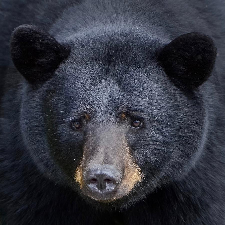

In [146]:
predict_image('black_new_pic.jpg')

grizzly


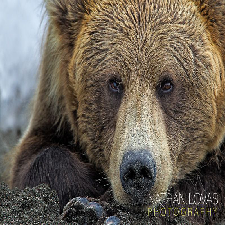

In [147]:
predict_image('grizzly_new_pic.jpg')

teddys


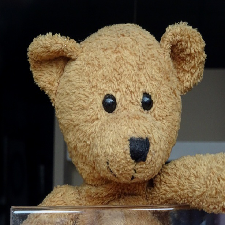

In [148]:
predict_image('teddy_new_pic.jpg')

### Interesante detalle: Esta red ha sido entrenada para que, al recibir cualquier tipo de imagen, la clasifique en 'black', 'grizzly' o 'teddy'.
1.Si quisiéramos clasificar la foto de 'ete' como 'no oso', por ejemplo, habría que crear una nueva carpeta 'no oso' que contenga imágenes aleatorias (que sean diferentes a imágenes de osos). 



2.De esta manera, la última capa de nuestra red neuronal sería Dense(4) en lugar de Dense(3), ya que ahora habría 4 posibles categorías.

grizzly


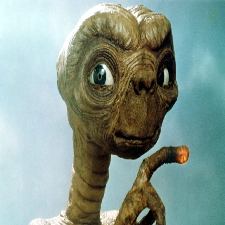

In [149]:
predict_image('ete.jpg')

black


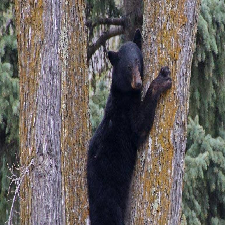

In [150]:
predict_image('black2.jpg')

black


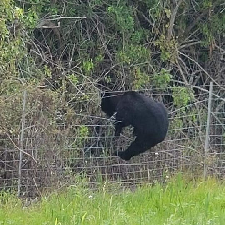

In [151]:
predict_image('black3.jpg')

grizzly


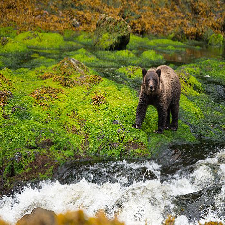

In [152]:
predict_image('grizzly2.jpg')

teddys


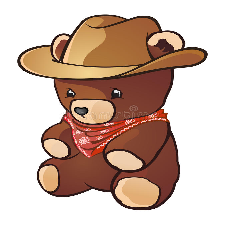

In [153]:
predict_image('teddy2.jpg')

# conclusiones

1. Transferir conocimiento con redes neuronales preentrenadas puede mejorar el modelo drásticamente, además de ahorrar muchas horas de computación.





2. Es importante encontrar la mejor combinación de hiperparámetros para sacar el mayor provecho a la red neuronal creada.





3. No hay que únicamente evaluar la precisión del modelo en 'train', sino también en 'validation' y 'test'. De esta manera, se puede claramente identificar si hay sobreajuste.

Este es el final. Muchas gracias!